In [2]:
# Imports
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import os
from datetime import datetime

In [3]:
# Load Data

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Normalise images to be in the range [-1, 1]
X_train = X_train / 127.5 - 1
X_test = X_test / 127.5 - 1

# Convert each 28x28 image into a 784 dimensional vector
features_count = np.prod(X_train.shape[1:])
X_train_flatened = X_train.reshape(n_train, features_count)
X_test_flatened = X_test.reshape(n_test, features_count)


#### --- Task 1 --- ####

In [ ]:
# PCA and Centroids 
# The centroid is calculated by averaging the coordinates of all the points in a cluster. This average gives you a single point that best represents the center of that cluster. 

# Reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_flatened)

# Create a scatter plot of the PCA data, colored by digit
fig = px.scatter(X_train_pca, x=0, y=1, color=y_train, title='PCA plot of the MNIST Dataset', width=1000, height=600)
fig.update_layout(xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')

# Create a DataFrame with the PCA data and digit labels
df_pca = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df_pca['digit'] = y_train

# Compute centroids for each class by taking the mean of PC1 and PC2
centroids = df_pca.groupby('digit')[['PC1', 'PC2']].mean()

# Colour mapping 
color_sequence = px.colors.qualitative.Plotly
unique_digits = sorted(df_pca['digit'].unique())
color_map = {digit: color_sequence[i % len(color_sequence)] for i, digit in enumerate(unique_digits)}

# Add centroids as larger markers, each colored according to its class
for digit, row in centroids.iterrows():
    fig.add_trace(
        go.Scatter(
                    x=[row['PC1']],
                    y=[row['PC2']],
                    mode='markers',
                    marker=dict(color=color_map[digit], size=15, symbol='diamond'),
                    name=f'Centroid {digit}'
                )
            )

fig.show()

In [ ]:
# Scree Plot - Shows the percentage of variance explained by each principal component

pca_full = PCA(n_components=50)
pca_full.fit(X_train_flatened)
variance_ratios = pca_full.explained_variance_ratio_
components = np.arange(1, len(variance_ratios) + 1)

df = pd.DataFrame({'Principal Component': components, 'Explained Variance': variance_ratios * 100})
df['Cumulative Variance'] = df['Explained Variance'].cumsum()

fig = px.bar(df, x='Principal Component', y='Explained Variance', title='Scree Plot & Cumulative Variance', labels={'Explained Variance': 'Percentage of Variance Explained'}, width=1000, height=500)
fig.add_scatter(x=df['Principal Component'], y=df['Cumulative Variance'], mode='lines+markers', name='Cumulative Variance', line=dict(color='red'))
fig.show()

In [18]:
# Questions / Notes

# Why is PCA a good option to visualise data?
# PCA is a good option to visualise data because it reduces the dimensionality of the data to 2 dimensions, which makes it easier to plot and understand.

# Observations
# Clustering of Classes - 784D to 2D space and visually see the differences between the different classes, which is not possible in the original 784D space.
# Separation of Certain Classes - Some digits form more isolated clusters. Eg digit 1 has a tight cluster. - Relatively simple and unique shape compared to other digits.
# Overlap Among Other Classes - Digit classes, such as 3, 5, and 8, have clusters that overlap considerably. This suggests that their differences may not be well captured by a linear projection onto the first two principal components.

# Q - Which classes can be linearly separated?
# A - 1 and 0 can be linearly separated. Where 3, 5 and 8 cannot be linearly separated.

# PCA Notes
# When you have high dimensional data, there are many directions in which the data can vary. The first principal component is the direction along which the data varies the most.
# By projecting your data onto the space defined by the top few principal components (often just two for visualisation), you reduce the dimensionality while retaining most of the information (variance) in the original data. 

#### --- Task 2 --- ####

In [6]:
# Main Functions


def prepare_data(digit_1, digit_2):

    # Convert each 28x28 image into a 784 dimensional vector
    features_count = np.prod(X_train.shape[1:])
    X_train_flatened = X_train.reshape(n_train, features_count)
    X_test_flatened = X_test.reshape(n_test, features_count)

    # Filter out for digit_1 and digit_2 for binary classification
    cond = (y_train == digit_1) + (y_train == digit_2)
    binary_x_train = X_train_flatened[cond, :]
    binary_y_train = y_train[cond] * 1.0

    # Normalise training labels
    binary_y_train[binary_y_train == digit_1] = -1
    binary_y_train[binary_y_train == digit_2] = 1

    # Filter out for digit_1 and digit_2 for binary classification
    cond_test = (y_test == digit_1) + (y_test == digit_2)
    binary_x_test = X_test_flatened[cond_test, :]
    binary_y_test = y_test[cond_test] * 1.0

    # Normalise test labels
    binary_y_test[binary_y_test == digit_1] = -1
    binary_y_test[binary_y_test == digit_2] = 1

    return binary_x_train, binary_y_train, binary_x_test, binary_y_test



def predict(x, w, b):

        # Compute the linear combination for each sample    
        z = np.dot(x, w) + b         

        # If z >= 0, predict 1, otherwise predict -1
        prediction = np.where(z >= 0, 1, -1)  

        return prediction



def run_epoch_perceptron(binary_x_train, binary_y_train, binary_x_test, binary_y_test, num_epochs=100, learning_rate=0.01):

    def train_perceptron(x_train, y_train, num_epochs, learning_rate):

        # Get the number of samples and features
        n_samples, n_features = x_train.shape

        # Initialise weights and bias to zero
        w = np.zeros(n_features)  
        b = 0.0                   
        
        # Lists to store accuracy values
        train_accuracies = []
        epochs = []
        
        # Batch of stochastic gradient descent
        for epoch in range(num_epochs):
            for i in range(n_samples):

                # Check if the sample is misclassified
                if y_train[i] * (np.dot(x_train[i], w) + b) <= 0:

                    # Update weights and bias using the perceptron rule
                    w += learning_rate * y_train[i] * x_train[i]
                    b += learning_rate * y_train[i]

            # Evaluate training progress at each epoch
            predictions = predict(x_train, w, b)
            accuracy = np.mean(predictions == y_train)
            train_accuracies.append(accuracy)
            epochs.append(epoch + 1)

        # Plot accuracy vs epochs
        fig = px.line(x=epochs, y=train_accuracies, title='Training Accuracy vs Epochs', labels={'x': 'Epoch', 'y': 'Accuracy'}, width=1000, height=500)
        fig.show()
        
        return w, b


    # Train the perceptron using the binary training data
    w, b = train_perceptron(binary_x_train, binary_y_train, num_epochs, learning_rate)

    # Predict on the training data
    train_predictions = predict(binary_x_train, w, b)
    train_accuracy = np.mean(train_predictions == binary_y_train)
    print('Final Training Accuracy:', train_accuracy)

    # Predict on the test data
    test_predictions = predict(binary_x_test, w, b)
    test_accuracy = np.mean(test_predictions == binary_y_test)
    print('Test Accuracy:', test_accuracy)

    return test_accuracy



def run_optimisation_perceptron(binary_x_train, binary_y_train, binary_x_test, binary_y_test, max_iters=1000, learning_rate=0.01, tolerance=1e-3):

    def optimise_perceptron(x, y, max_iters, learning_rate, tolerance):

        # Initialise variables
        iter = 0
        error = np.inf
        error_list = []
        n,m = x.shape
        rng = np.random.default_rng()
        w = rng.random(m)
        b = rng.random()

        # While the iteration is less than the maximum number of iterations and the error is greater than the tolerance
        while (iter <= max_iters) & (error > tolerance):
            
            # Predict all samples
            predictions = predict(x, w, b)
            
            # Identify misclassified samples
            misclassified_indices = np.where(predictions != y)[0]
            
            # Compute current error (fraction of misclassified samples)
            error = len(misclassified_indices) / n
            error_list.append(error)
            
            # If no misclassifications, we can stop early
            if len(misclassified_indices) == 0:
                break

            # Update w, b for each misclassified sample
            for i in misclassified_indices:
                w += learning_rate * y[i] * x[i]
                b += learning_rate * y[i]

            iter += 1

        return w, b, error_list


    # Optimise on the training set
    w_opt, b_opt, error_list = optimise_perceptron(binary_x_train, binary_y_train, max_iters, learning_rate, tolerance)

    # Evaluate on training
    train_pred = predict(binary_x_train, w_opt, b_opt)
    train_accuracy = np.mean(train_pred == binary_y_train)
    print('Final Training Accuracy:', train_accuracy)

    # Evaluate on test
    test_pred = predict(binary_x_test, w_opt, b_opt)
    test_accuracy = np.mean(test_pred == binary_y_test)
    print('Test Accuracy:', test_accuracy)

    # Error Curve
    df_error = pd.DataFrame({'Iteration': list(range(1, len(error_list) + 1)), 'Misclassification Error': error_list})
    fig_error = px.line(df_error, x='Iteration', y='Misclassification Error', title='Perceptron Training Error', markers=True, width=1000, height=500)
    fig_error.show()

    # Visualise the learned weights as an image
    w_image = w_opt.reshape(28, 28)
    fig_weights = px.imshow(w_image, color_continuous_scale='RdBu', title='Learned Weight Image', width=1000, height=500)
    fig_weights.show()

    return test_accuracy



In [ ]:
# Run

digits = {'sample_1': (1, 0), 'sample_2': (8, 3), 'sample_3': (5, 3), 'sample_4': (8, 7), 'sample_5': (2, 9)}
results = {}

for run, (digit_1, digit_2) in enumerate(digits.values()):
    print(f'\n\nRun: {run + 1 }: -- Training for digits {digit_1} and {digit_2} --\n\n')
    print(' -- Epoch Perceptron Training --\n')
    binary_x_train, binary_y_train, binary_x_test, binary_y_test = prepare_data(digit_1, digit_2)
    epoch_test_accuracy = run_epoch_perceptron(binary_x_train, binary_y_train, binary_x_test, binary_y_test)
    print('\n -- Optimisation Perceptron Training --\n')
    optimisation_test_accuracy = run_optimisation_perceptron(binary_x_train, binary_y_train, binary_x_test, binary_y_test)  
    results[f'run_{run + 1}'] = {'digit_1': round(digit_1, 0), 'digit_2': round(digit_2, 0), 'epoch_test_accuracy': round(epoch_test_accuracy, 2), 'optimisation_test_accuracy': round(optimisation_test_accuracy, 2)}

df = pd.DataFrame(results)
display(df)

#### --- Task 3 --- ####

In [6]:
# Plot Training and Testing Accuracy Curves

def plot(history):

    train_acc = history.history['accuracy'][-1] * 100
    test_acc = history.history['val_accuracy'][-1] * 100
    print(f'Training accuracy: {train_acc:.2f}%')
    print(f'Test accuracy: {test_acc:.2f}%')

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Training vs. Testing Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def multi_plot(names, histories):
    
    plt.figure(figsize=(15,5))

    for i in range(len(histories)):
        plt.plot(histories[i].history['val_accuracy'])
        
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.98,1])
    plt.show()


# Set up TensorBoard logging
log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Log histograms of weights/biases every epoch
    write_graph=True,  # Visualise the model graph
    write_images=True, # Save images of weights
    update_freq='epoch', # Log metrics at the end of each epoch
)

In [7]:
# Load Data

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255
y_train = np.eye(10)[y_train]
X_test = X_test/ 255
y_test = np.eye(10)[y_test]

In [ ]:
# Base MLP Model 

model = Sequential([
    Flatten(input_shape=(28, 28)),         # Flatten 28x28 images to 784
    Dense(1000, activation='relu'),        # First hidden layer
    Dense(1000, activation='relu'),        # Second hidden layer
    Dense(10, activation='softmax')        # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=50,
    epochs=10,
    validation_data=(X_test, y_test)
)

plot(history)

In [ ]:
# Second MLP Model 

model = Sequential([
    Flatten(input_shape=(28, 28)),        
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),        
    Dense(500, activation='relu'),  
    Dense(500, activation='relu'),        
    Dense(10, activation='softmax')        
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=50,
    epochs=10,
    validation_data=(X_test, y_test)
)

plot(history)

#### --- Task 4 --- ####

In [9]:
# Load and prepare data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]
print(f'Training images: {n_train}, Test images: {n_test}')

# Reshape and normalise the data
x_train = x_train.reshape((n_train, 28, 28, 1)) / 255.0
x_test = x_test.reshape((n_test, 28, 28, 1)) / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Training images: 60000, Test images: 10000


Epoch 1/10


/Users/leon/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9019 - loss: 0.3256 - val_accuracy: 0.9852 - val_loss: 0.0467
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9850 - loss: 0.0501 - val_accuracy: 0.9870 - val_loss: 0.0425
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9911 - loss: 0.0305 - val_accuracy: 0.9899 - val_loss: 0.0316
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9937 - loss: 0.0207 - val_accuracy: 0.9877 - val_loss: 0.0443
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.9897 - val_loss: 0.0358
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9965 - loss: 0.0112 - val_accuracy: 0.9889 - val_loss: 0.0375
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9961 - loss: 0.0110 - val_accuracy: 0.9903 - val_loss: 0.0414
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9973 - loss: 0.00

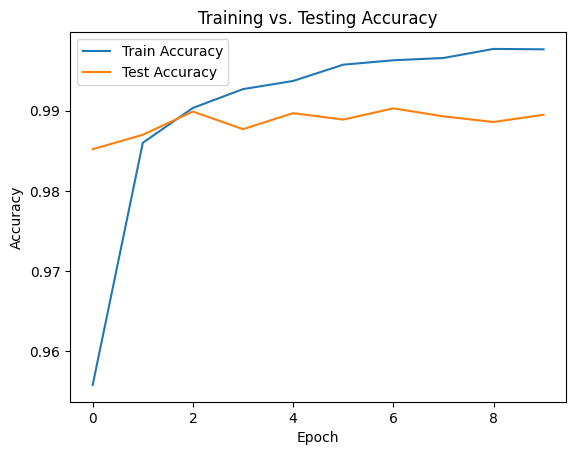

In [10]:
# Base CNN Model 

model = Sequential([
    Conv2D(32, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    Conv2D(128, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    Flatten(),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=50, epochs=10, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

plot(history)

In [ ]:
# Optimsed CNN Model 1

model = Sequential([
    Conv2D(8, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(16, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    Flatten(),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=50, epochs=10, validation_data=(x_test, y_test))

plot(history)

model.summary()

### Multimodel Runs

In [64]:
# Run multiple models 

def multi_model_run(models, names):

    nets = len(models)

    histories = [0] * nets

    for j in range(nets):

        histories[j] = models[j].fit(x_train, y_train, batch_size=50, epochs=10, validation_data=(x_test, y_test))

        print('CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}'.format(
            names[j], 10, 
            max(histories[j].history['accuracy']),  
            max(histories[j].history['val_accuracy'])  
        ))

    return histories    

In [ ]:
# What is the optimal CNN depth?

nets = 4
models = [0] * nets
names = ['CNN-1', 'CNN-2', 'CNN-3', 'CNN-4']
histories = [0] * nets  

for j in range(nets):

    models[j] = Sequential()
    models[j].add(Conv2D(16, kernel_size=(4,4), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,1)))
        
    if j>0:
        models[j].add(Conv2D(32, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu'))
        
    if j>1:
        models[j].add(Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu'))

    if j>2:
        models[j].add(Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu'))

    models[j].add(Flatten())
    models[j].add(Dense(10, activation='softmax'))

    models[j].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


histories = multi_model_run(models, names)

multi_plot(names, histories)

In [ ]:
# What is the optimal number of feature maps (width)?

nets = 6
models = [0] * nets
names = ['8 maps','16 maps','24 maps','32 maps','48 maps','64 maps']

for j in range(6):

    models[j] = Sequential([
        Conv2D(j*8+8, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(28,28,1)),
        Conv2D(j*16+16, kernel_size=(4,4), strides=(2,2), activation='relu'),
        Conv2D(j*32+32, kernel_size=(4,4), strides=(2,2), activation='relu'),
        Flatten(),
        Dense(10, activation='softmax')
    ])

    models[j].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

histories = multi_model_run(models, names)

multi_plot(names, histories)

In [ ]:
# What is the optimal dense layer size? ( beyond scope of this assignment)

nets = 8
model = [0] * nets
names = ['0N', '32N', '64N', '128N', '256N', '512N', '1024N', '2048N']


for j in range(nets):

    model[j] = Sequential()
    model[j].add(Conv2D(16, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(28,28,1)))
    model[j].add(Conv2D(32, kernel_size=(4,4), strides=(2,2), activation='relu'))
    model[j].add(Flatten())
    
    if j>0:
        model[j].add(Dense(2**(j+4), activation='relu'))

    model[j].add(Dense(10, activation='softmax'))
    
    model[j].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


histories = multi_model_run(models, names)

multi_plot(names, histories)

In [17]:
plot_model = model

### Task 5

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.datasets import mnist

# Load and prepare data (Task 4)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]
print(f'Training images: {n_train}, Test images: {n_test}')

# Reshape and normalize the data
x_train = x_train.reshape((n_train, 28, 28, 1)) / 255.0
x_test = x_test.reshape((n_test, 28, 28, 1)) / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define the CNN model (Task 4)
model = Sequential([
    Conv2D(32, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    Conv2D(128, kernel_size=(4, 4), strides=(2, 2), activation='relu'),
    Flatten(),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model (Task 4)
history = model.fit(x_train, y_train, batch_size=50, epochs=10, 
                    validation_data=(x_test, y_test))

# Force model initialization with a dummy prediction
dummy_input = np.zeros((1, 28, 28, 1))  # Single empty image
model.predict(dummy_input)  # This builds the model's graph


Training images: 60000, Test images: 10000
Epoch 1/10


/Users/leon/.pyenv/versions/3.10.0/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1200/1200 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9019 - loss: 0.3184 - val_accuracy: 0.9827 - val_loss: 0.0569
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9854 - loss: 0.0472 - val_accuracy: 0.9872 - val_loss: 0.0385
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9904 - loss: 0.0332 - val_accuracy: 0.9871 - val_loss: 0.0434
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9925 - loss: 0.0245 - val_accuracy: 0.9874 - val_loss: 0.0457
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9947 - loss: 0.0170 - val_accuracy: 0.9893 - val_loss: 0.0387
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9950 - loss: 0.0150 - val_accuracy: 0.9889 - val_loss: 0.0382
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9972 - loss: 0.0084 - val_accuracy: 0.9893 - val_loss: 0.0409
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9971 - loss: 0.00

array([[3.5377461e-04, 5.0056094e-01, 4.5024627e-01, 7.0946207e-03,
        1.1744625e-04, 3.6710367e-02, 3.3836020e-04, 4.0569049e-03,
        3.0419155e-04, 2.1709123e-04]], dtype=float32)

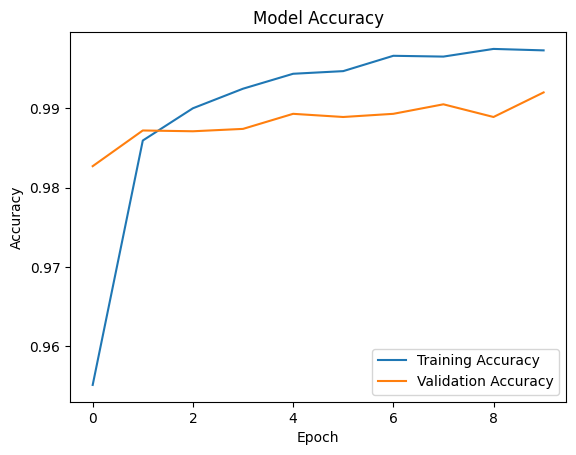

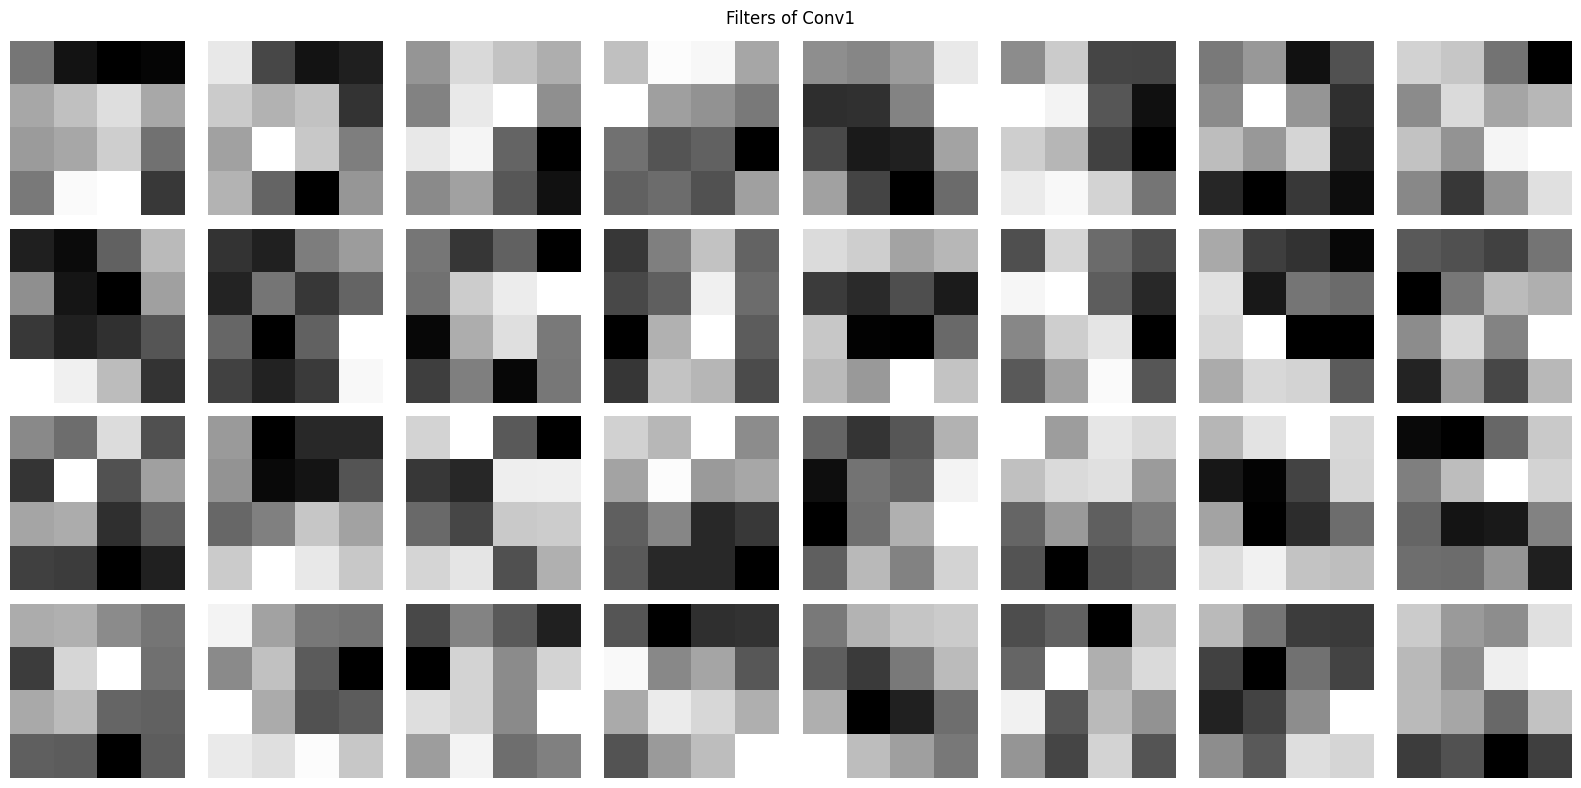

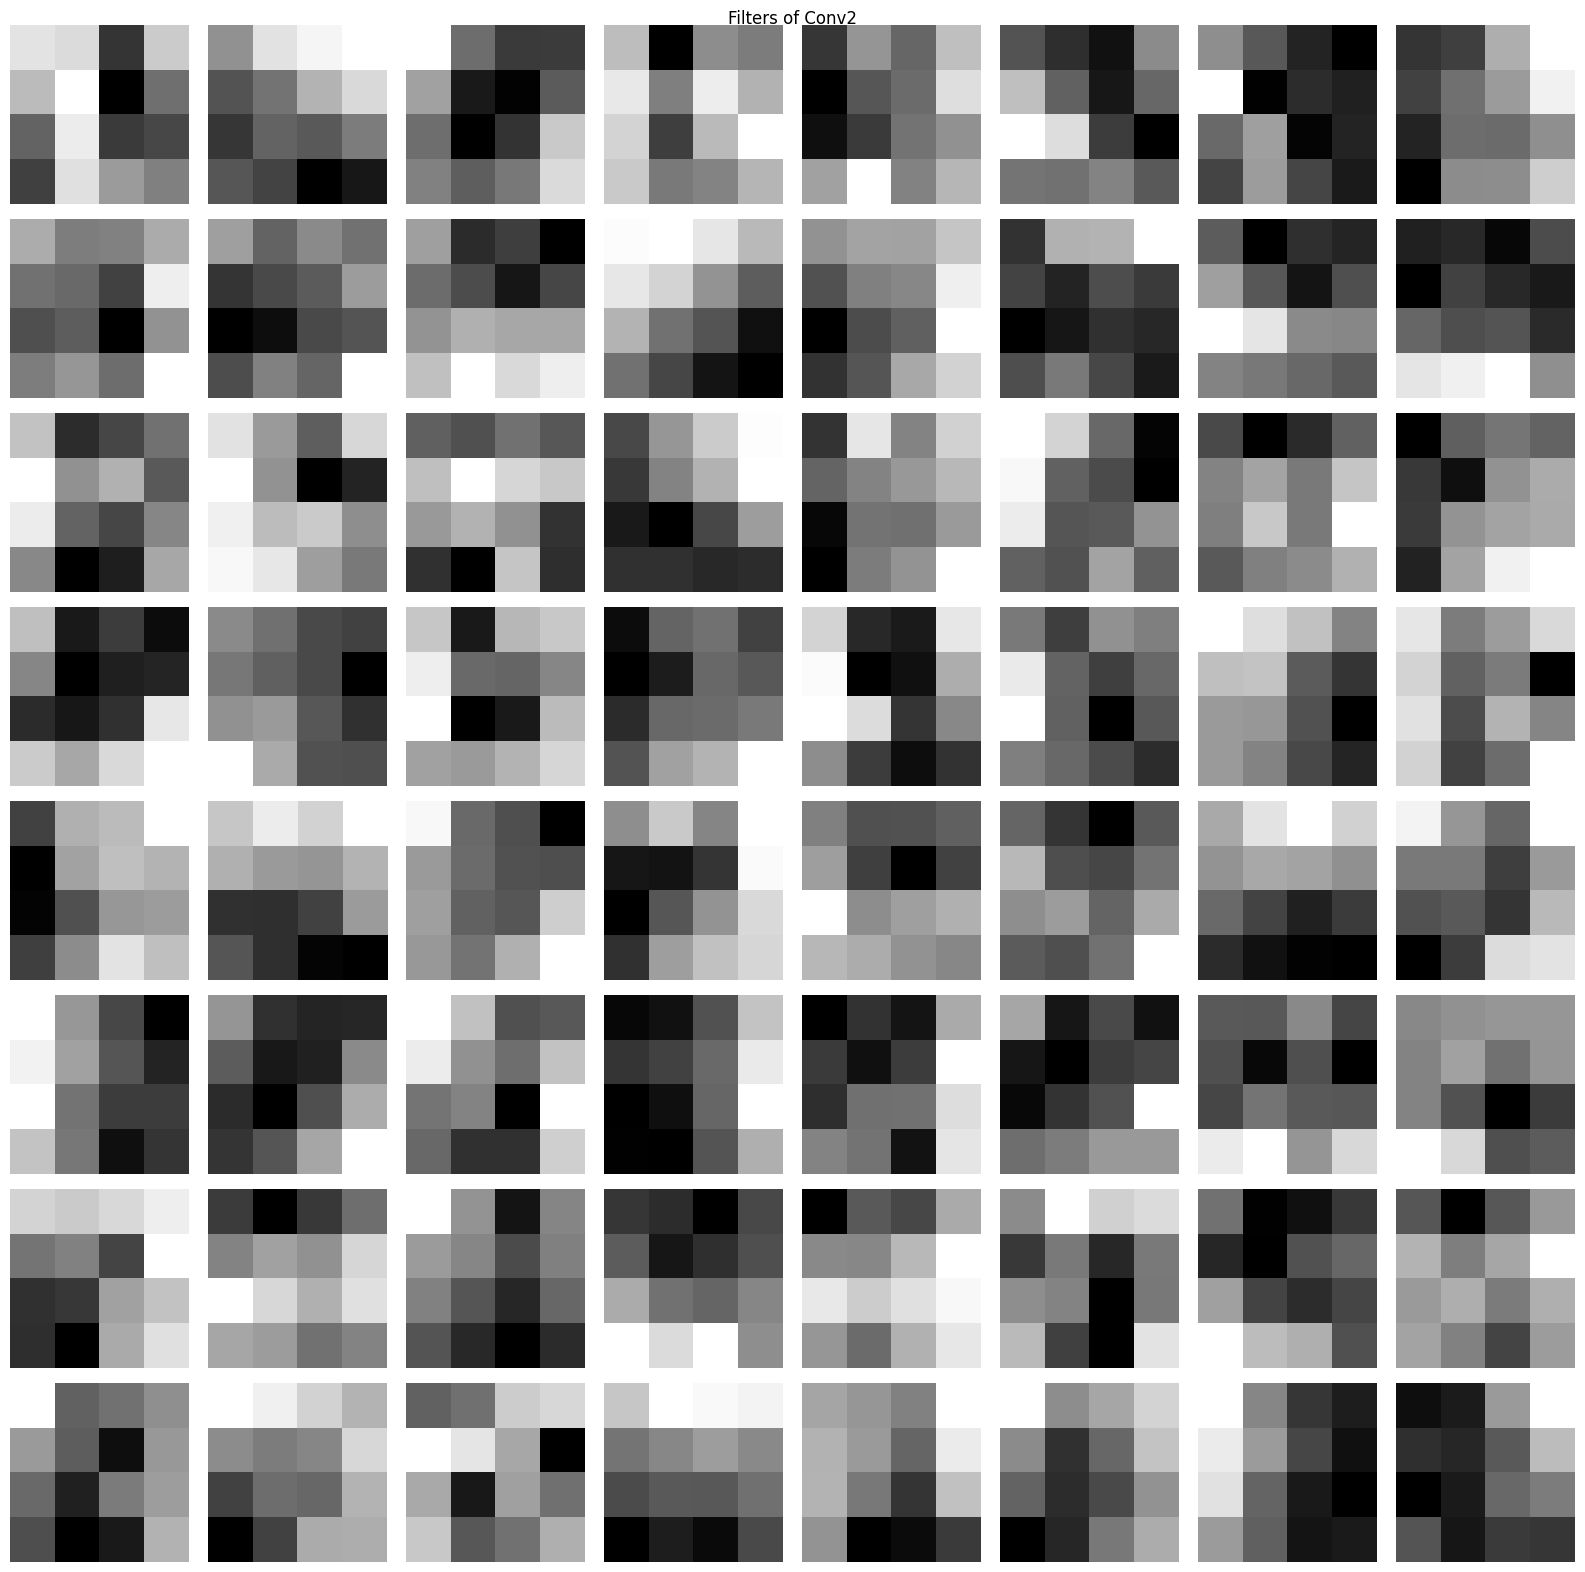

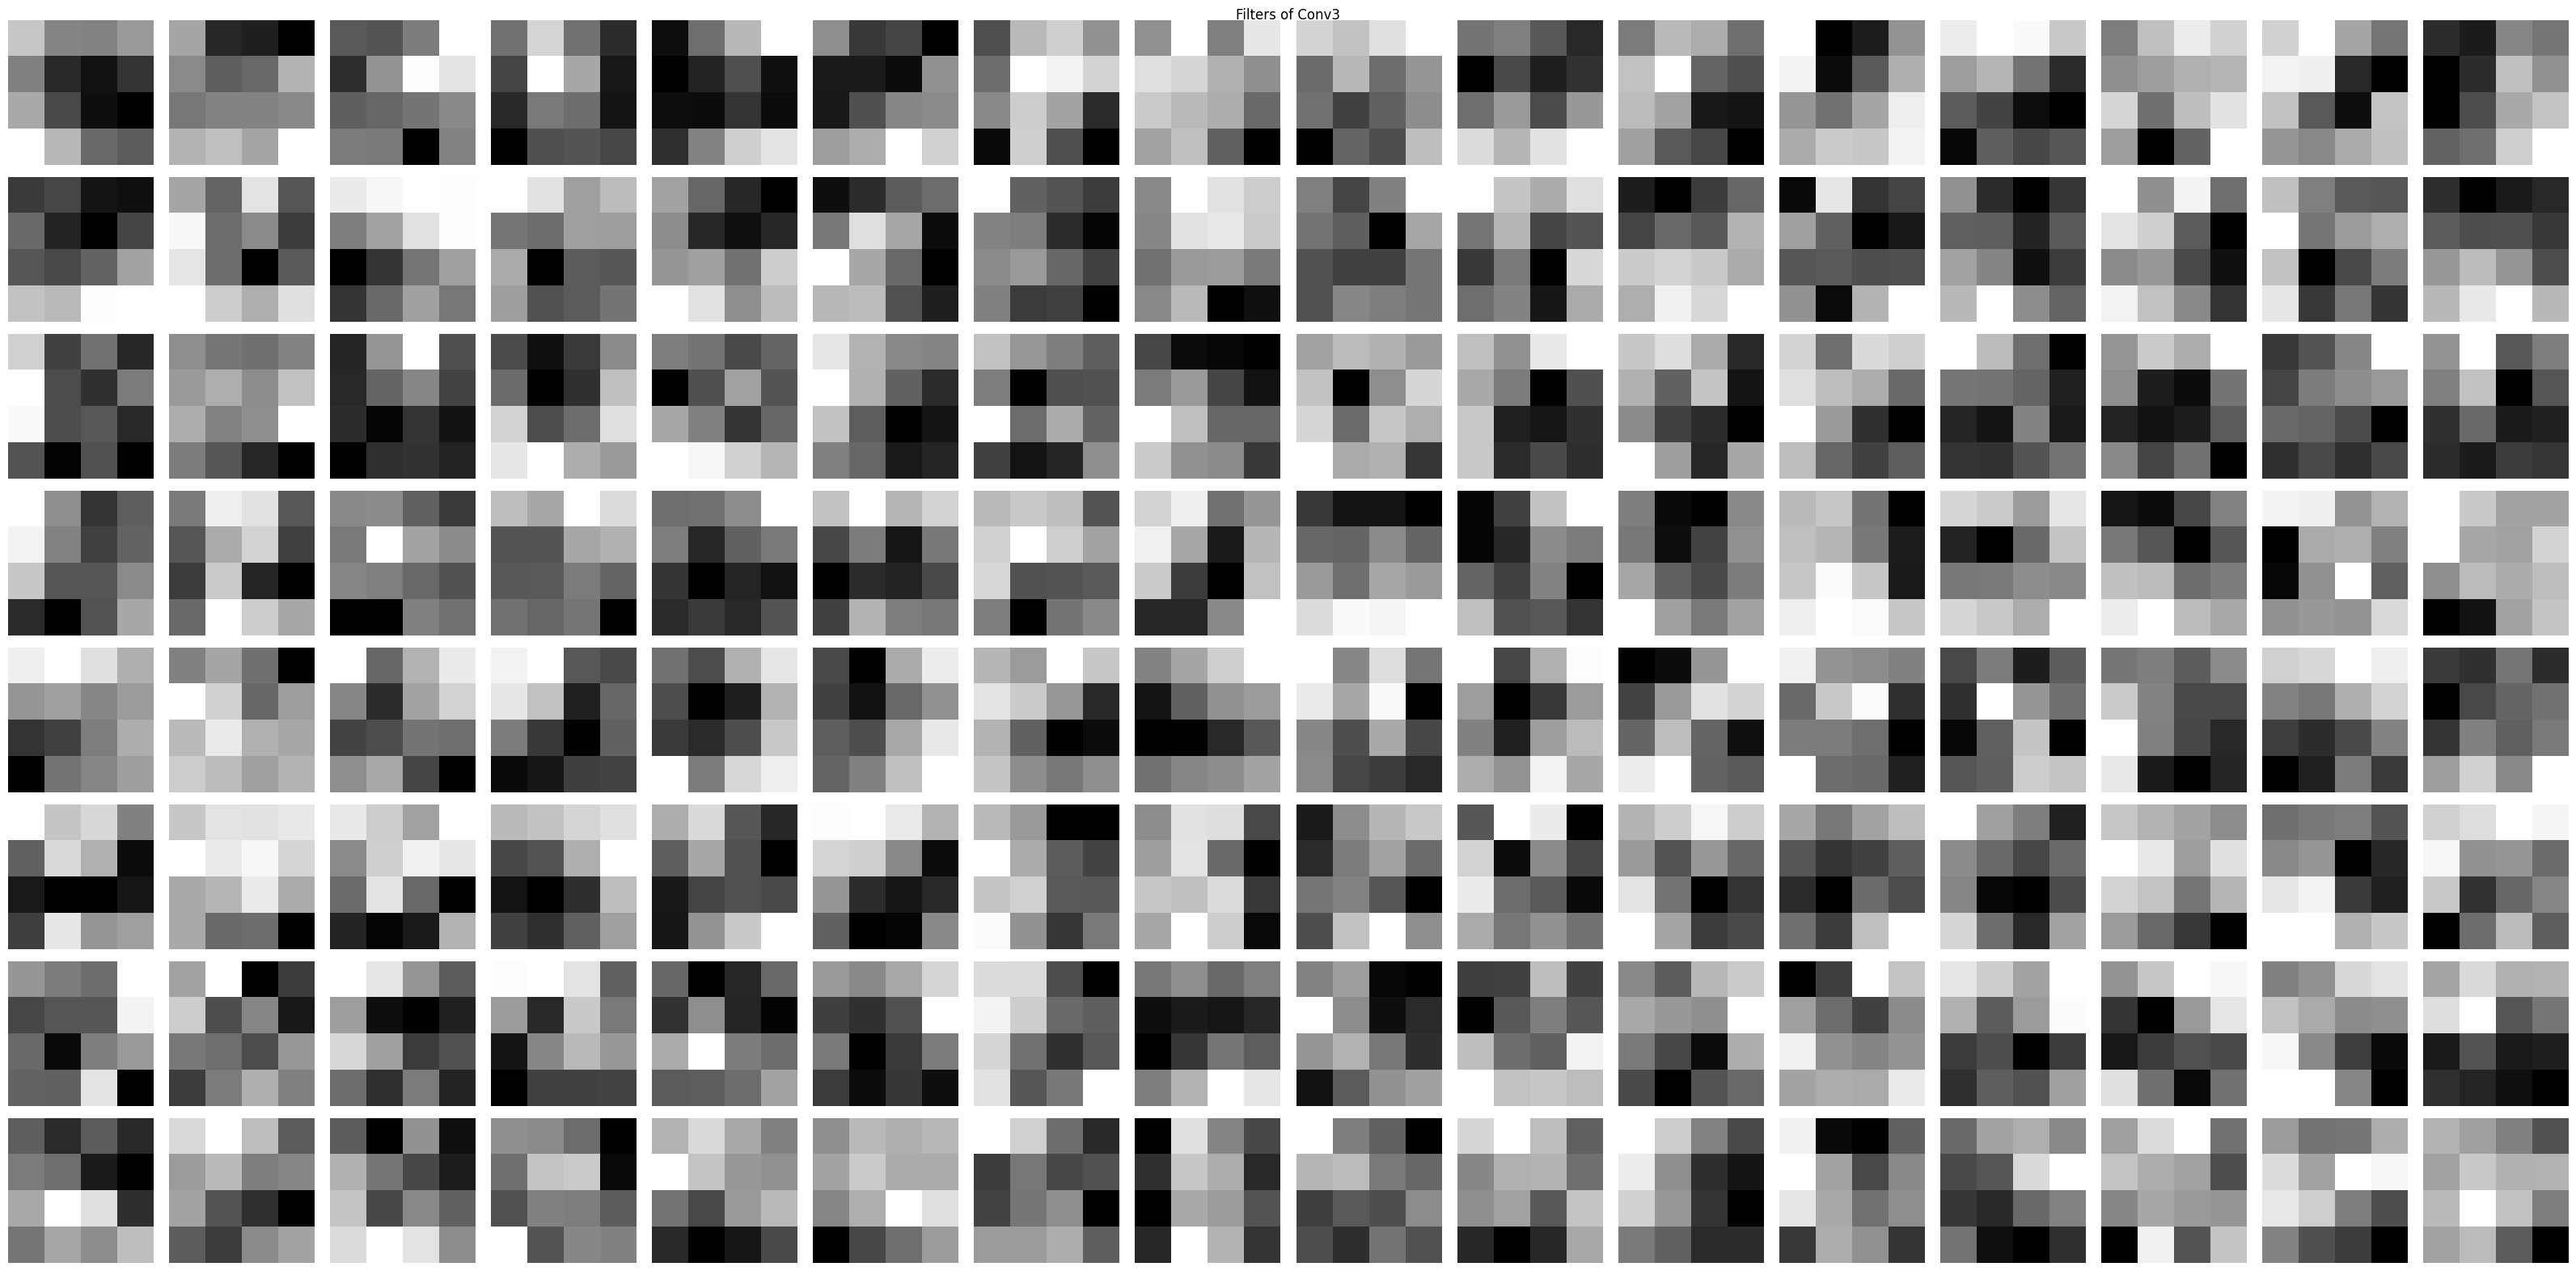

ValueError: The layer sequential_6 has never been called and thus has no defined input.

In [28]:

# Function to plot training history
def plot(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot(history)

# --- Task 5 Begins Here ---

# Part 1: Plotting Filters
def plot_filters(layer_weights, layer_name, grid_size):
    filters = layer_weights
    if filters.shape[2] == 1:  # For Conv1
        filters = filters[:, :, 0, :]
    else:  # For Conv2 and Conv3, mean across input channels
        filters = np.mean(filters, axis=2)
    
    num_filters = filters.shape[-1]
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Fixed typo here
    axes = axes.flatten()
    
    for i in range(num_filters):
        ax = axes[i]
        filter_img = filters[:, :, i]
        filter_min, filter_max = filter_img.min(), filter_img.max()
        if filter_max > filter_min:
            filter_img = (filter_img - filter_min) / (filter_max - filter_min)
        ax.imshow(filter_img, cmap='gray')
        ax.axis('off')
    
    for i in range(num_filters, rows * cols):
        axes[i].axis('off')
    
    plt.suptitle(f'Filters of {layer_name}')
    plt.tight_layout()
    plt.show()

# Extract and plot filters
conv1_weights = plot_model.layers[0].get_weights()[0]  # (4,4,1,32)
conv2_weights = plot_model.layers[1].get_weights()[0]  # (4,4,32,64)
conv3_weights = plot_model.layers[2].get_weights()[0]  # (4,4,64,128)

plot_filters(conv1_weights, 'Conv1', (4, 8))
plot_filters(conv2_weights, 'Conv2', (8, 8))
plot_filters(conv3_weights, 'Conv3', (8, 16))

# Part 2: Plotting Activations
idx_2 = np.where(np.argmax(y_train, axis=1) == 2)[0][0]
idx_9 = np.where(np.argmax(y_train, axis=1) == 9)[0][0]


from tensorflow.keras.models import Model

# Get all Conv2D layers of the original model
conv_layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]

# Create a new model that will return the outputs (feature maps) for each Conv2D layer
conv_outputs = [layer.output for layer in conv_layers]
activation_model = Model(inputs=model.input, outputs=conv_outputs)



# Get activations
image_2 = x_train[idx_2]  # Replace idx_2 with your index
image_9 = x_train[idx_9]  # Replace idx_9 with your index
activations_2 = activation_model.predict([np.expand_dims(image_2, axis=0)])
activations_9 = activation_model.predict([np.expand_dims(image_9, axis=0)])

def plot_activations(activations, layer_name, grid_size, image_title):
    num_feature_maps = activations.shape[-1]
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    
    for i in range(num_feature_maps):
        ax = axes[i]
        feature_map = activations[0, :, :, i]
        fm_min, fm_max = feature_map.min(), feature_map.max()
        if fm_max > fm_min:
            feature_map = (feature_map - fm_min) / (fm_max - fm_min)
        ax.imshow(feature_map, cmap='gray')
        ax.axis('off')
    
    for i in range(num_feature_maps, rows * cols):
        axes[i].axis('off')
    
    plt.suptitle(f'Activations of {layer_name} for {image_title}')
    plt.tight_layout()
    plt.show()


for i, activation in enumerate(activations_2):
    layer_name = f'Conv{i+1}'
    grid_sizes = [(4, 8), (8, 8), (8, 16)]  # Example grid sizes
    plot_activations(activation, layer_name, grid_sizes[i], "Digit '2'")

for i, activation in enumerate(activations_9):
    layer_name = f'Conv{i+1}'
    grid_sizes = [(4, 8), (8, 8), (8, 16)]
    plot_activations(activation, layer_name, grid_sizes[i], "Digit '9'")


# Plot activations
for i, activation in enumerate(activations_2):
    layer_name = f'Conv{i+1}'
    grid_sizes = [(4, 8), (8, 8), (8, 16)]
    plot_activations(activation, layer_name, grid_sizes[i], "Digit '2'")

for i, activation in enumerate(activations_9):
    layer_name = f'Conv{i+1}'
    grid_sizes = [(4, 8), (8, 8), (8, 16)]
    plot_activations(activation, layer_name, grid_sizes[i], "Digit '9'")

# Part 3: Deep Dream
def deep_dream(model, target_class, iterations=100, step_size=0.01):
    img = tf.Variable(np.random.uniform(0, 1, (1, 28, 28, 1)), dtype=tf.float32)
    
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(img)
            predictions = model(img)
            loss = -predictions[0, target_class]
        grads = tape.gradient(loss, img)
        grads /= (tf.math.reduce_std(grads) + 1e-8)
        img.assign_add(step_size * grads)
        img.assign(tf.clip_by_value(img, 0, 1))
    
    return img.numpy()[0, :, :, 0]


# Generate and plot deep dream images
dream_2 = deep_dream(model, 2)
dream_9 = deep_dream(model, 9)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dream_2, cmap='gray')
plt.title("Deep Dream for Class '2'")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(dream_9, cmap='gray')
plt.title("Deep Dream for Class '9'")
plt.axis('off')
plt.tight_layout()
plt.show()